## Семинар: "Методы оптимизации"

In [1]:
from functools import partial

import numpy as np
import torch
from tqdm.auto import tqdm
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from matplotlib import animation
from mpl_toolkits import mplot3d
from matplotlib.gridspec import GridSpec
from torchvision import datasets, transforms
from IPython.display import HTML
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import pandas as pd
import random

%matplotlib inline
plt.rc('animation', html='html5')

На этом семинаре мы попробуем реализовать и сравнить различные методы оптимизации: SGD, Momentum, NAG, Adagrad, RMSProp, AdaDelta.

### Реализация методов

Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

In [2]:
# https://github.com/dzlab/deepprojects/blob/master/visualization/Optimizers_in_Action.ipynb

def grid_samples(center=[0, 0], offset=5, size=100):
    range1 = np.linspace(center[0]-offset, center[0]+offset, size)
    range2 = np.linspace(center[1]-offset, center[1]+offset, size)
    return torch.from_numpy(np.stack(np.meshgrid(range1, range2))).float()


def mse(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1)


def msre(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1).sqrt()


def mae(y, y_hat):
    return ((y - y_hat).abs()).mean(axis=-1)


class LossAnimator:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.size = len(X)

    def loss_func(self, W, loss):
        shape = W.shape
        return loss((self.X @ W.view(shape[0], -1)).T, self.y).view(shape[1:])

    def plot_loss_funcs(self, weights, fcts, titles, view=(20, 50)):
        num_fcts = len(fcts)
        fig = plt.figure(figsize=(7 * num_fcts,7))
        for i in range(num_fcts):
            loss = self.loss_func(weights, loss=fcts[i])
            ax = fig.add_subplot(1, num_fcts, i+1, projection='3d')
            ax.plot_surface(*weights, loss, cmap='viridis')
            ax.set_xlabel('w0'); ax.set_ylabel('w1'); ax.set_zlabel('Loss')
            ax.set_title(titles[i])
            ax.view_init(*view)

    def _init_animation(self, epochs, train_data):
        self.train_data = train_data
        self.epochs = epochs
        self.nmethods = len(train_data)

        weights = grid_samples(offset=5)

        max_loss = max([data['losses'].max() for data in train_data.values()])
        loss_curve = self.loss_func(weights, loss=mse)
        colors = cm.rainbow(np.linspace(0, 1, self.nmethods))


        self.fig = plt.figure(figsize=(14, 8))
        self.gs = GridSpec(2, 2, width_ratios=[1, 2.5])

        self.ax0 = self.fig.add_subplot(self.gs[0,0])
        self.lines0 = {
            name: self.ax0.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax0.scatter(self.X[:,0], self.y, c='orange', label='Ground truth')
        self.ax0.set_ylim(self.y.min(), self.y.max())
        self.ax0.set_title('Ground truth & Model', fontsize=16)
        self.ax0.legend(loc='lower right')

        self.ax1 = self.fig.add_subplot(self.gs[:,1], projection='3d')
        self.ax1.plot_surface(*weights, loss_curve-0.5, cmap='viridis', alpha=0.8)
        self.ax1.view_init(50, 70)
        self.lines1 = {
            name: self.ax1.plot3D([], [], [], c=c, marker='o', alpha=0.9, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax1.set_title('Loss', fontsize=16, pad=20)
        self.ax1.set_xlabel('w0')
        self.ax1.set_ylabel('w1')
        self.ax1.set_zlabel('Loss')
        self.ax1.legend()

        self.ax2 = self.fig.add_subplot(self.gs[1,0])
        self.lines2 = {
            name: self.ax2.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax2.set_title('Loss', fontsize=16)
        self.ax2.set_ylabel('loss')
        self.ax2.set_ybound(0, max_loss)
        self.ax2.set_xlim(0, epochs)
        self.ax2.legend(loc='center right')

        self.fig.tight_layout()
        self.fig.subplots_adjust(top=0.85)

        plt.close()

        return self.fig

    def _animate(self, i):
        steps = np.arange(i+1)
        left = max(0, i-20)
        for name, data in self.train_data.items():
            # plot ground truth & model
            self.lines0[name].set_data(self.X[:, 0], self.X @ data['weights'][i])

            # plot loss (output of the sampling)
            self.lines1[name].set_data(data['weights'][left:i+1, 0], data['weights'][left:i+1, 1])
            self.lines1[name].set_3d_properties(data['losses'][left:i+1])

            self.lines2[name].set_data(steps, data['losses'][:i+1])

        self.fig.suptitle(f'Epoch: {i}/{self.epochs}', fontsize=22)

    def animate(self, epochs, train_data, step_skip=1):
        self._init_animation(epochs, train_data)
        anim = animation.FuncAnimation(self.fig, self._animate, frames=range(0, epochs, step_skip), interval=100 * step_skip)
        return HTML(anim.to_html5_video())

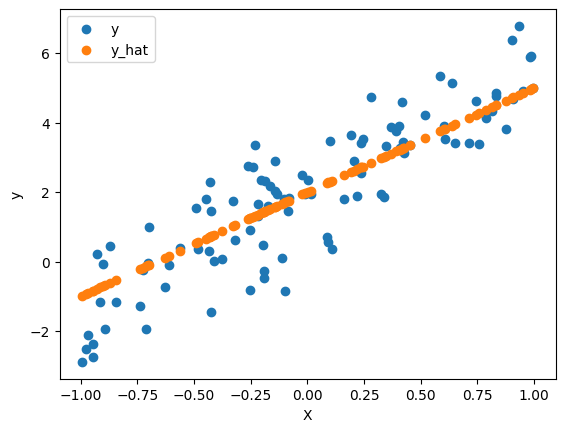

In [3]:
size = 100
X = torch.ones(size, 2)
X[:, 0].uniform_(-1., 1)

y_hat = 3 * X[:, 0] + 2
y = y_hat + torch.randn(size)

loss_animator = LossAnimator(X, y)

plt.scatter(loss_animator.X[:,0], loss_animator.y, label='y');
plt.scatter(loss_animator.X[:,0], y_hat, label='y_hat');
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

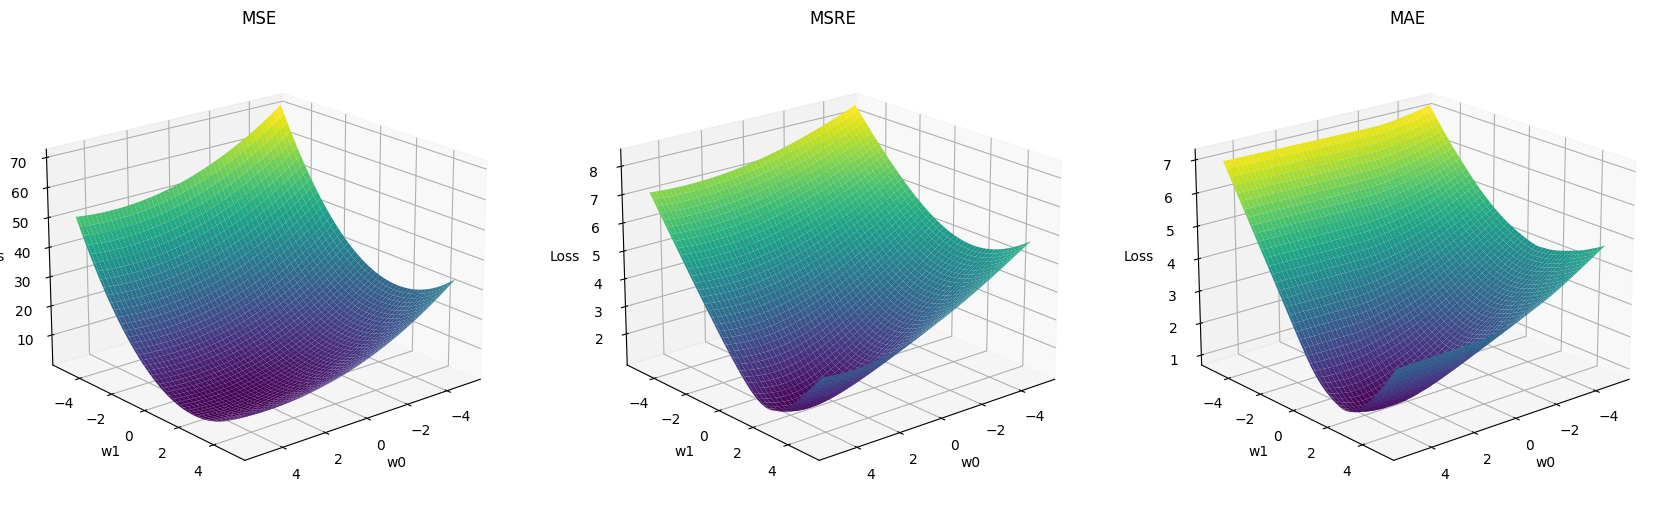

In [4]:
weights = grid_samples()
loss_animator.plot_loss_funcs(weights, [mse, msre, mae], ['MSE', 'MSRE', 'MAE'])

In [5]:
class Optimizer:
    def __init__(self, params):
        self.params = list(params)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

    def pre_step(self):
        pass

    def step(self):
        pass

    def update_param(self, p):
        raise NotImplementedError()


In [6]:
def optimize_function(fn, optim, optim_args, start_point, num_iter = 50):
    weigths = nn.Parameter(torch.FloatTensor(start_point), requires_grad=True)

    optim = optim(params=[weigths], **optim_args)
    points = []
    losses = []
    for i in range(num_iter):
        if hasattr(optim, 'pre_step'):
            optim.pre_step()
        loss = fn(weigths)
        points.append(weigths.data.detach().clone())
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    points = torch.stack(points, axis=0)
    losses = torch.FloatTensor(losses)
    return points, losses


In [7]:
def compare_optimizers(
    loss_animator,
    fn,
    optim_list,
    start_point,
    num_iter = 50,
    step_skip = 1
):
    data = {}
    loss_func = partial(loss_animator.loss_func, loss=fn)
    for name, optim, args in tqdm(optim_list):
        points, losses = optimize_function(loss_func, optim, args, start_point, num_iter)
        data[name] = {
            'weights': points,
            'losses': losses,
        }

    return loss_animator.animate(num_iter, data, step_skip=step_skip)

#### SGD
$$\theta_t = \theta_{t-1} - \eta \sum_{i_1, ..., i_k} \nabla_{\theta} J_{i} (\theta_{t-1})$$

In [8]:
class SGD(Optimizer):
    def __init__(self, params, lr=1e-2):
        super().__init__(params)
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue
                p -= self.lr * p.grad


#### Momentum
$$\nu_t=\gamma \nu_{t-1} + \eta_t \nabla_{\theta} J_{i} (\theta_{t-1})$$
$$\theta_t = \theta_{t-1} - \nu_t$$

In [9]:
class Momentum(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma

        self.prev_momentum = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                prev_momentum = self.prev_momentum[i]
                self.prev_momentum[i] = self.gamma * prev_momentum + self.lr * p.grad
                p -= self.prev_momentum[i]

#### Nesterov Accelerated Gradient (NAG)
$$\nu_t=\gamma \nu_{t-1} + \eta_t \nabla_{\theta} J_{i} (\theta_{t-1} - \gamma \nu_{t-1})$$
$$\theta_t = \theta_{t-1} - \nu_t$$

In [10]:
class NAG(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma

        self.prev_momentum = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                prev_momentum = self.prev_momentum[i]
                self.prev_momentum[i] = self.gamma * prev_momentum + self.lr * p.grad
                p -= (1 + self.gamma) * self.prev_momentum[i] - self.gamma * prev_momentum

#### AdaGrad
$$G_t = \sum_{k=0}^t g_{k}^2$$
$$\theta_{t} = \theta_{t-1} - \frac{\eta}{\sqrt{G_{t-1} + ϵ}} \cdot g_{t-1}$$

In [11]:
class AdaGrad(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2):
        super().__init__(params)
        self.epsilon = epsilon
        self.eta = eta

        self.G = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                self.G[i] += p.grad ** 2
                p -= self.eta * p.grad / torch.sqrt(self.G[i] + self.epsilon)

#### RMSProp
$$G_t = \gamma G_{t-1} + (1 - \gamma) g_t^2$$
$$\theta_{t} = \theta_{t-1} - \frac{\eta}{\sqrt{G_{t-1} + ϵ}} \cdot g_{t-1}$$

In [12]:
class RMSProp(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2, gamma=0.9):
        super().__init__(params)
        self.eta = eta
        self.epsilon = epsilon
        self.gamma = gamma

        self.G = [torch.zeros(p.shape) for p in self.params]


    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                self.G[i] = self.gamma * self.G[i] + (1 - self.gamma) * (p.grad ** 2)
                p -= self.eta / torch.sqrt(self.G[i] + self.epsilon) * p.grad

In [13]:
from functools import partial

points, losses = optimize_function(
    partial(loss_animator.loss_func, loss=mse),
    SGD,
     {'lr': 1e-2},
    start_point=[-4, -4],
    num_iter=100
)

In [14]:
compare_optimizers(
    loss_animator,
    mae,
    [
        ['SGD', SGD, {'lr': 1e-1}],
        ['Momentum', NAG, {'lr': 1e-1}],
        ['NAG', NAG, {'lr': 1e-1}],
        ['AdaGrad', AdaGrad, {'eta' : 1}],
        ['RMSProp', RMSProp, {'eta' : 1}],
    ],
    start_point=[-4, -4],
    num_iter=100
)

  0%|          | 0/5 [00:00<?, ?it/s]

###  Домашнее задание: Обучение нейронной сети + Подбор шага

В этом задании вам нужно:
1) Реализовать Adam, AdamW и обучить сверточную нейросеть на MNIST. Сравнить графики обучения для SGD, Adam и AdamW. **(2 балла)**
2) Реализовать LinearLR и CosineAnnealingLR. Обучить сверточную нейросеть на MNIST с SGD, Adam, AdamW с LinearLR, CosineAnnealingLR. Сравните графики изменения loss-функции и точности (суммарно должно быть 9 экспериментов, 3 из которых покрываются пунктом 1). **(3 балла)**

Ссылки:
- https://arxiv.org/abs/1711.05101 (AdamW, статья)
- https://docs.pytorch.org/docs/stable/generated/torch.optim.AdamW.html (AdamW, PyTorch)
- https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LinearLR.html (LinearLR, PyTorch)
- https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html (CosineAnnealingLR, PyTorch)

In [15]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2025-10-01 20:34:50--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2025-10-01 20:34:50--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [        <=>         ]  33.20M  21.2MB/s    in 1.6s    

2025-10-01 20:34:52 (21.2 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False



transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [17]:
class LRScheduler:
    def __init__(self, optimizer: Optimizer):
        self.optimizer = optimizer
        self.last_iter = 0

    def step(self):
        self.last_iter += 1

In [18]:
class LinearLR(LRScheduler):
    def __init__(
        self,
        optimizer: Optimizer,
        start_factor: float = 0.1,
        end_factor: float = 1.0,
        total_iters: int = 100
    ):
        super().__init__(optimizer)
        self.start_factor = start_factor
        self.end_factor = end_factor
        self.total_iters = total_iters


    def step(self):
        super().step()
        factor = self.start_factor + (self.end_factor - self.start_factor) * min(1.0, self.last_iter / self.total_iters)
        if isinstance(self.optimizer, torch.optim.Optimizer):
            base_lr = self.optimizer.param_groups[0]['initial_lr'] if 'initial_lr' in self.optimizer.param_groups[0] else self.optimizer.param_groups[0]['lr']
            self.optimizer.param_groups[0]['lr'] = base_lr * factor
        else:
            self.optimizer.lr = self.optimizer.lr * factor
class CosineAnnealing(LRScheduler):
    def __init__(
            self,
            optimizer: Optimizer,
            T_max: int = 20,
            eta_min: float = 0.01
        ):
        super().__init__(optimizer)
        self.T_max = T_max
        self.eta_min = eta_min
        self.base_lr = optimizer.lr if not(isinstance(self.optimizer, torch.optim.Optimizer)) else self.optimizer.param_groups[0]['lr']

    def step(self):
        super().step()
        cos_inner = np.pi * (self.last_iter % self.T_max) / self.T_max
        new_lr = self.eta_min + (self.base_lr - self.eta_min) * (1 + np.cos(cos_inner)) / 2
        if isinstance(self.optimizer, torch.optim.Optimizer):
            self.optimizer.param_groups[0]['lr'] = new_lr
        else:
            self.optimizer.lr = new_lr

In [19]:
class Adam(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8):
        super().__init__(params)
        self.lr = lr
        self.betas = betas
        self.eps = eps

        self.m = [torch.zeros_like(p) for p in self.params]
        self.v = [torch.zeros_like(p) for p in self.params]
        self.t = 0

    def step(self):
        self.t += 1
        beta1, beta2 = self.betas
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                g = p.grad
                self.m[i] = beta1 * self.m[i] + (1 - beta1) * g
                self.v[i] = beta2 * self.v[i] + (1 - beta2) * (g * g)

                m_hat = self.m[i] / (1 - beta1 ** self.t)
                v_hat = self.v[i] / (1 - beta2 ** self.t)

                p -= self.lr * m_hat / (torch.sqrt(v_hat) + self.eps)


In [20]:
class AdamW(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-2):
        super().__init__(params)
        self.lr = lr
        self.betas = betas
        self.eps = eps
        self.weight_decay = weight_decay

        self.m = [torch.zeros_like(p) for p in self.params]
        self.v = [torch.zeros_like(p) for p in self.params]
        self.t = 0

    def step(self):
        self.t += 1
        beta1, beta2 = self.betas
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                g = p.grad
                p -= self.lr * self.weight_decay * p
                self.m[i] = beta1 * self.m[i] + (1 - beta1) * g
                self.v[i] = beta2 * self.v[i] + (1 - beta2) * (g * g)
                m_hat = self.m[i] / (1 - beta1 ** self.t)
                v_hat = self.v[i] / (1 - beta2 ** self.t)

                p -= self.lr * m_hat / (torch.sqrt(v_hat) + self.eps)


In [21]:
seed_everything(42)

In [22]:
class NN_model(nn.Module):
    def __init__(self, param1=32, k=3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=param1, kernel_size=k),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4),
        )

        with torch.no_grad():
            zeros = torch.zeros(1, 1, 28, 28)
            val = self.features(zeros).view(1, -1).shape[1]


        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(val, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

    def fit(self,optimizer,n_epochs=5,scheduler = None):
        return train(self, optimizer, n_epochs=n_epochs,scheduler=scheduler)

    def count_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


In [23]:
def train(model, optimizer, n_epochs=5, scheduler=None):
    logs = []
    loss_func = nn.NLLLoss()

    for epoch in range(n_epochs):
        model.train()
        curr_loss = 0 
        curr_correct = 0
        curr_total = 0

        for x_train, y_train in tqdm(train_loader, leave=False):
            x_train = x_train.to(device)
            y_train = y_train.to(device)

            y_pred = model(x_train)
            loss = loss_func(y_pred, y_train)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            curr_loss+=loss.item() * x_train.size(0)
            curr_correct+=(y_pred.argmax(dim=-1) == y_train).sum().item()
            curr_total+=x_train.size(0)

        train_loss = curr_loss/curr_total
        train_acc  = curr_correct/curr_total

        if scheduler is not None:
            scheduler.step()
            if isinstance(optimizer, torch.optim.Optimizer):
                curr_lr = optimizer.param_groups[0]['lr']
            else:
                curr_lr = optimizer.lr
        else:
            curr_lr = getattr(optimizer, "lr", None)
        
        
        
        model.eval()
        val_losses = []
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for x_val, y_val in tqdm(test_loader, leave=False):
                x_val = x_val.to(device)
                y_val = y_val.to(device)
                y_pred = model(x_val)
                vloss = loss_func(y_pred, y_val)
                val_losses.append(vloss.item())
                val_correct += (y_pred.argmax(dim=-1) == y_val).sum().item()
                val_total += x_val.size(0)

        val_loss = float(np.mean(val_losses))
        val_acc  = val_correct/val_total

        print(f'Epoch: {epoch:02d} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f}'
              + (f' | val_loss: {val_loss:.4f} | val_acc: {val_acc:.4f}' if epoch%2 == 0 else '')
              + (f' | lr: {curr_lr:.5f}' if curr_lr is not None else ''))

        logs.append({
            "epoch": epoch,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc,
            "lr": curr_lr
        })

    return logs


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 00 | train_loss: 0.4284 | train_acc: 0.8814 | val_loss: 0.1859 | val_acc: 0.9446


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 01 | train_loss: 0.1455 | train_acc: 0.9569


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 02 | train_loss: 0.0989 | train_acc: 0.9708 | val_loss: 0.0822 | val_acc: 0.9752


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 00 | train_loss: 0.1846 | train_acc: 0.9437 | val_loss: 0.0704 | val_acc: 0.9767 | lr: 0.00100


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 01 | train_loss: 0.0698 | train_acc: 0.9781 | lr: 0.00100


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 02 | train_loss: 0.0518 | train_acc: 0.9836 | val_loss: 0.0438 | val_acc: 0.9840 | lr: 0.00100


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 00 | train_loss: 0.1751 | train_acc: 0.9466 | val_loss: 0.0717 | val_acc: 0.9770 | lr: 0.00100


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 01 | train_loss: 0.0686 | train_acc: 0.9790 | lr: 0.00100


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 02 | train_loss: 0.0499 | train_acc: 0.9840 | val_loss: 0.0440 | val_acc: 0.9847 | lr: 0.00100


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 00 | train_loss: 0.4053 | train_acc: 0.8928 | val_loss: 0.1717 | val_acc: 0.9503 | lr: 0.00400


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 01 | train_loss: 0.1463 | train_acc: 0.9585 | lr: 0.00280


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 02 | train_loss: 0.1201 | train_acc: 0.9658 | val_loss: 0.1049 | val_acc: 0.9703 | lr: 0.00280


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 00 | train_loss: 0.1771 | train_acc: 0.9466 | val_loss: 0.0881 | val_acc: 0.9706 | lr: 0.00040


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 01 | train_loss: 0.0563 | train_acc: 0.9825 | lr: 0.00028


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 02 | train_loss: 0.0422 | train_acc: 0.9875 | val_loss: 0.0441 | val_acc: 0.9855 | lr: 0.00028


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 00 | train_loss: 0.1634 | train_acc: 0.9502 | val_loss: 0.0728 | val_acc: 0.9761 | lr: 0.00040


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 01 | train_loss: 0.0547 | train_acc: 0.9838 | lr: 0.00028


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 02 | train_loss: 0.0416 | train_acc: 0.9879 | val_loss: 0.0436 | val_acc: 0.9854 | lr: 0.00028


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 00 | train_loss: 0.4049 | train_acc: 0.8890 | val_loss: 0.1700 | val_acc: 0.9512 | lr: 0.00750


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 01 | train_loss: 0.1459 | train_acc: 0.9576 | lr: 0.00251


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 02 | train_loss: 0.1095 | train_acc: 0.9686 | val_loss: 0.0970 | val_acc: 0.9722 | lr: 0.01000


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 00 | train_loss: 0.1694 | train_acc: 0.9480 | val_loss: 0.0691 | val_acc: 0.9772 | lr: 0.00075


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 01 | train_loss: 0.0645 | train_acc: 0.9798 | lr: 0.00026


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 02 | train_loss: 0.0382 | train_acc: 0.9889 | val_loss: 0.0415 | val_acc: 0.9852 | lr: 0.00100


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 00 | train_loss: 0.1642 | train_acc: 0.9513 | val_loss: 0.0709 | val_acc: 0.9764 | lr: 0.00075


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 01 | train_loss: 0.0618 | train_acc: 0.9806 | lr: 0.00026


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 02 | train_loss: 0.0360 | train_acc: 0.9891 | val_loss: 0.0429 | val_acc: 0.9851 | lr: 0.00100


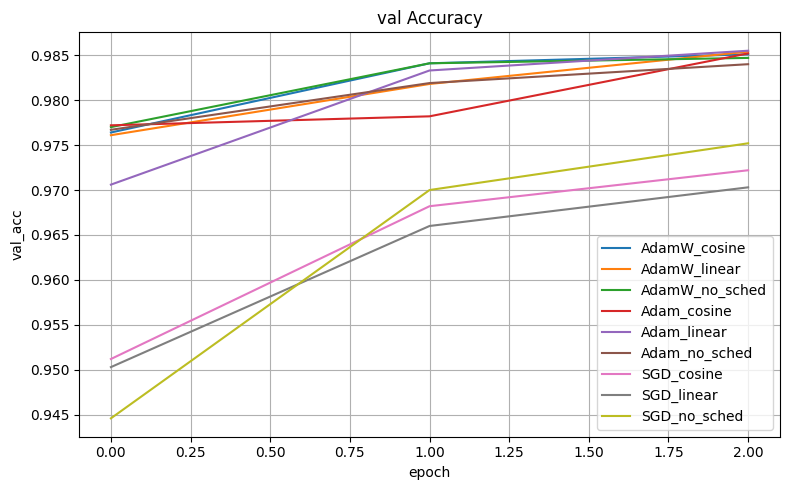

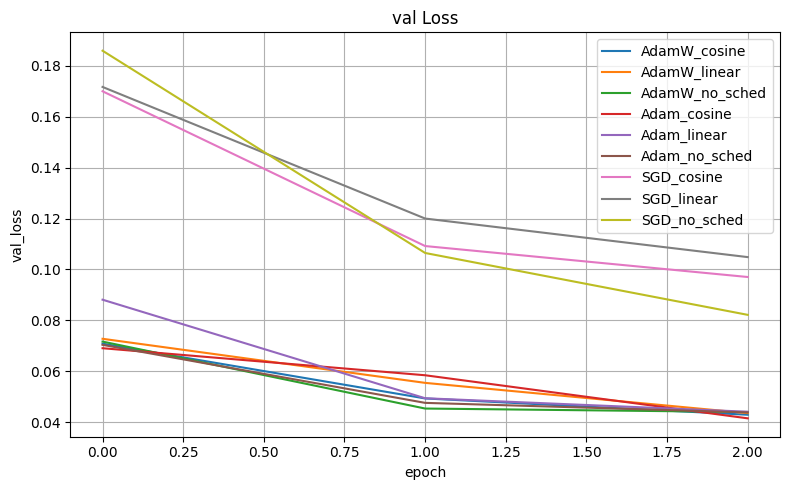

           run  best_val_acc  params
   Adam_linear        0.9855  149194
  AdamW_linear        0.9854  149194
   Adam_cosine        0.9852  149194
  AdamW_cosine        0.9851  149194
AdamW_no_sched        0.9847  149194
 Adam_no_sched        0.9840  149194
  SGD_no_sched        0.9752  149194
    SGD_cosine        0.9722  149194
    SGD_linear        0.9703  149194

Best run: Adam_linear | best_val_acc: 0.9855 | params: 149194


In [24]:
configs = [
    {"name": "SGD_no_sched", "opt": "sgd", "sched": None},
    {"name": "Adam_no_sched", "opt": "adam", "sched": None},
    {"name": "AdamW_no_sched", "opt": "adamw", "sched": None},

    {"name": "SGD_linear", "opt": "sgd", "sched": "linear"},
    {"name": "Adam_linear", "opt": "adam", "sched": "linear"},
    {"name": "AdamW_linear", "opt": "adamw", "sched": "linear"},

    {"name": "SGD_cosine", "opt": "sgd", "sched": "cosine"},
    {"name": "Adam_cosine", "opt": "adam", "sched": "cosine"},
    {"name": "AdamW_cosine", "opt": "adamw", "sched": "cosine"},
]

n_epochs = 3
results = []
all_logs = []

for cfg in configs:
    model = NN_model(param1=32, k=3).to(device)
    params = model.count_params()

    if cfg["opt"] == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
    elif cfg["opt"] == "adam":
        optimizer = Adam(model.parameters(), lr=1e-3)
    elif cfg["opt"] == "adamw":
        optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2) 


    scheduler = None
    if cfg["sched"] == "linear":
        scheduler = LinearLR(optimizer, start_factor=0.1, end_factor=1.0, total_iters=n_epochs)
    elif cfg["sched"] == "cosine":
        scheduler = CosineAnnealing(optimizer, T_max=n_epochs, eta_min=1e-5)
    
    logs = model.fit(optimizer, n_epochs=n_epochs, scheduler=scheduler)
    for row in logs:
        row = {"run": cfg["name"], "params": params, **row}
        all_logs.append(row)

    val_epochs = [r for r in logs if not np.isnan(r["val_acc"])]
    
    best_val = max((r["val_acc"] for r in val_epochs), 
                   default=float("nan"))
    
    results.append({"run": cfg["name"], "best_val_acc": best_val, "params": params})

df = pd.DataFrame(all_logs)
pivot_acc  = df.pivot(index="epoch", columns="run", values="val_acc")
pivot_loss = df.pivot(index="epoch", columns="run", values="val_loss")
plt.figure(figsize=(8,5))
for colums in pivot_acc.columns:
    plt.plot(pivot_acc.index, pivot_acc[colums], label=colums)
plt.xlabel("epoch")
plt.ylabel("val_acc")
plt.title("val Accuracy") 
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
plt.figure(figsize=(8,5))
for colums in pivot_loss.columns:
    plt.plot(pivot_loss.index, pivot_loss[colums], label=colums)
plt.xlabel("epoch")
plt.ylabel("val_loss")
plt.title("val Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
summary = pd.DataFrame(results).sort_values("best_val_acc", ascending=False)
print(summary.to_string(index=False))
if not summary.empty:
    print("\nBest run:", summary.iloc[0]["run"],
          "| best_val_acc:", f'{summary.iloc[0]["best_val_acc"]:.4f}',
          "| params:", int(summary.iloc[0]["params"]))


#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

- Your text here

Здесь вы можете оставить комментарии по лекции или семинару:

- Your text here